Analysis to calculate the diffusivities, Nernst-Einstein conductivites, radial distribution function, coordination number and ion pair lifetimes of molten NaCl

Assumes the path to PyLAT/src has been added to PYTHONPATH

# Import Classes

import and initialize required classes for calculations

In [1]:
from MSD import MSD
from calcDiffusivity import calcdiffusivity
from calcCOM import calcCOM
from getTimeData import gettimedata
from getMolData import getmoldata
from COMradial import COMradialdistribution
from getAtomCharges import getatomcharges
from calcNEconductivity import calcNEconductivity
from getCoordinationNumber import getcoordinationnumber
from ionpair import ionpair


c = calcCOM()
m = MSD()
cd = calcdiffusivity()
gt = gettimedata()
gm = getmoldata()
crd = COMradialdistribution()
gc = getatomcharges()
ne = calcNEconductivity()
ip = ionpair()
gc = getatomcharges()
gcn = getcoordinationnumber()

# General Input
input used by all calculations

In [2]:
output = {}
datfilename = 'mol.data'
trjfilename=['mol.lammpstrj']
logfilename='log.lammps'
temp=1300
nummoltype=[864,864]
moltypel=['Na','Cl']
moltype = []
for i in range(0,len(moltypel)):
    for j in range(0,nummoltype[i]):
        moltype.append(int(i))
verb=2
ver=True

# Input for Radial Distribution Function and Coordination Number

In [3]:
RDF_maxr=None
RDF_binsize=0.1
RDF_Timesteps = 1000

# Input for Ion Pair Lifetime

In [4]:
IPL_skip=0

# Input for Diffusivity

In [5]:
MSD_skip=0
MSD_num_init=None
D_Tolerance=0.075

# Preliminary Calculations

In [6]:
output['Conductivity'] = {}
output['Conductivity']['units'] = 'S/m'

n = gc.findnumatoms(datfilename)
(molcharges, atomcharges,n) = gc.getmolcharges(datfilename,n)
molcharge = gc.molchargedict(molcharges, moltypel, moltype)
tsjump = gt.getjump(trjfilename[0])
dt = gt.getdt(logfilename)
(V, Lx, Ly, Lz) = gcn.getvolume(trjfilename[0])
(comx, comy, comz, Lx, Ly, Lz, Lx2, Ly2, Lz2) = c.calcCOM(trjfilename,datfilename, ver)

COM calculation 100.00% complete


# Calculation of Radial Distribution Function and Coordination Number

In [7]:
output['RDF'] = {}
output['RDF']['units'] = 'unitless, angstroms'
output = crd.runradial(datfilename, comx, comy, comz, Lx, Ly, Lz, Lx2, Ly2, Lz2, output, nummoltype, moltypel, moltype,RDF_Timesteps, ver,RDF_maxr,RDF_binsize)
output = gcn.calccoordinationnumber(output, nummoltype, moltypel, V)

# Plotting RDF

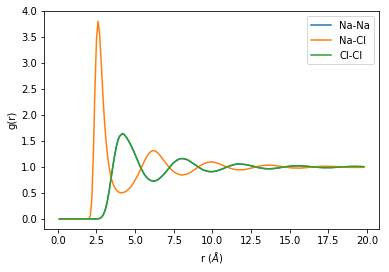

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

dist = output['RDF']['distance']
NaNa = output['RDF']['Na-Na']
NaCl = output['RDF']['Na-Cl']
ClCl = output['RDF']['Cl-Cl']

plt.xlabel(r'r ($\AA$)')
plt.ylabel('g(r)')
plt.plot(dist,NaNa,label='Na-Na')
plt.plot(dist,NaCl,label='Na-Cl')
plt.plot(dist,NaNa,label='Cl-Cl')
plt.legend()

# Calculation of Ion Pair Lifetime

In [9]:
ip.runionpair(comx,comy,comz,Lx,Ly,Lz,moltypel,moltype,tsjump,dt,output,ver,IPL_skip)

IPL distance calculation 14.07% complete

# Ion Pair Lifetime Results

Chlorine around sodium: 0.974829130494
Sodium around Clorine: 0.967411999742


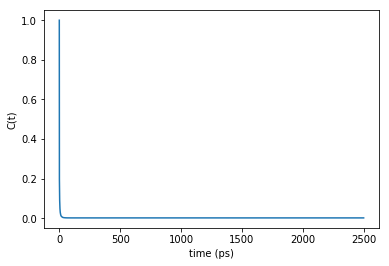

In [10]:
plt.figure()

Correlation = output['Ion_Pair_Lifetime']['Na around Cl correlation']
Time = output['Ion_Pair_Lifetime']['Correlation_Time']
plt.xlabel('time (ps)')
plt.ylabel('C(t)')
plt.plot(Time,Correlation)

print('Chlorine around sodium: {}'.format(output['Ion_Pair_Lifetime']['Cl around Na'][4]))
print('Sodium around Clorine: {}'.format(output['Ion_Pair_Lifetime']['Na around Cl'][4]))

# Calculation of MSD, Diffusivity and Nernst-Einstein Conductivity

In [11]:
output = m.runMSD(comx, comy, comz, Lx, Ly, Lz, Lx2, Ly2, Lz2, moltype, moltypel, dt, tsjump, output, ver, MSD_skip, MSD_num_init)
cd.calcdiffusivity(output, moltypel, dt,D_Tolerance)
output = ne.calcNEconductivity(output, molcharge, Lx, Ly, Lz, nummoltype, moltypel, temp)

unwrap complete
MSD calculation 49.97% complete

# Diffusivity Results

Diffusivity of sodium: 1.32568724574e-08 m^2/s
Diffusivity of chlorine: 1.20292297281e-08 m^2/s


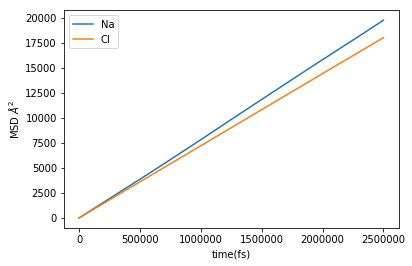

In [12]:
plt.figure()

Na_MSD = output['MSD']['Na']
Cl_MSD = output['MSD']['Cl']
MSD_time = output['MSD']['time']
plt.xlabel('time(fs)')
plt.ylabel(r'MSD $\AA^2$')
plt.plot(MSD_time,Na_MSD,label='Na')
plt.plot(MSD_time,Cl_MSD,label='Cl')
plt.legend()

print('Diffusivity of sodium: {} m^2/s'.format(output['Diffusivity']['Na']))
print('Diffusivity of chlorine: {} m^2/s'.format(output['Diffusivity']['Cl']))
